In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
import csv
import random
import time
import math
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets

from random import shuffle
from collections import defaultdict
from copy import deepcopy
from itertools import chain

from __future__ import print_function
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from google.colab import files

In [402]:
hyperparam_tuning_amsgrad = False 
hyperparam_tuning_adam = False
num_epochs_hyp = 10 

num_epochs = 13

valid_size = 0
num_train_hyp = 250*128 #train size for hyperparameter tuning
num_valid_hyp = 20*128 # valid size for hp tuning
batch_size = 128
# Learning the parameters using Amsgrad optimization with categorical cross-entropy loss. The learning rate is initially set to 0.001.
criterion = nn.CrossEntropyLoss()
alphas = np.logspace(-1,-2.5,8)
betas = np.linspace(0.994,0.996,3)
alphas_adam = np.logspace(0,-2,9)[1:]
betas_adam = np.linspace(0.99,0.999,3)

print('alphas=',alphas)
print('betas=',betas)
print('alphas_adam=',alphas_adam)
print('betas_adam=',betas_adam)



alphas= [0.1        0.06105402 0.03727594 0.02275846 0.01389495 0.00848343
 0.00517947 0.00316228]
betas= [0.994 0.995 0.996]
alphas_adam= [0.56234133 0.31622777 0.17782794 0.1        0.05623413 0.03162278
 0.01778279 0.01      ]
betas_adam= [0.99   0.9945 0.999 ]


In [0]:
# The below code implements Optimizer class and is taken from pytorch's github implementation

required = object()


class Optimizer(object):
    """Base class for all optimizers.

    Arguments:
        params (iterable): an iterable of :class:`Variable` s or
            :class:`dict` s. Specifies what Variables should be optimized.
        defaults: (dict): a dict containing default values of optimization
            options (used when a parameter group doesn't specify them).
    """

    def __init__(self, params, defaults):
        self.defaults = defaults

        if isinstance(params, Variable) or torch.is_tensor(params):
            raise TypeError("params argument given to the optimizer should be "
                            "an iterable of Variables or dicts, but got " +
                            torch.typename(params))

        self.state = defaultdict(dict)
        self.param_groups = []

        param_groups = list(params)
        if len(param_groups) == 0:
            raise ValueError("optimizer got an empty parameter list")
        if not isinstance(param_groups[0], dict):
            param_groups = [{'params': param_groups}]

        for param_group in param_groups:
            self.add_param_group(param_group)

    def __getstate__(self):
        return {
            'state': self.state,
            'param_groups': self.param_groups,
        }

    def __setstate__(self, state):
        self.__dict__.update(state)

    def state_dict(self):
        """Returns the state of the optimizer as a :class:`dict`.

        It contains two entries:

        * state - a dict holding current optimization state. Its content
            differs between optimizer classes.
        * param_groups - a dict containing all parameter groups
        """
        # Save ids instead of Variables
        def pack_group(group):
            packed = {k: v for k, v in group.items() if k != 'params'}
            packed['params'] = [id(p) for p in group['params']]
            return packed
        param_groups = [pack_group(g) for g in self.param_groups]
        # Remap state to use ids as keys
        packed_state = {(id(k) if isinstance(k, Variable) else k): v
                        for k, v in self.state.items()}
        return {
            'state': packed_state,
            'param_groups': param_groups,
        }

    def load_state_dict(self, state_dict):
        """Loads the optimizer state.

        Arguments:
            state_dict (dict): optimizer state. Should be an object returned
                from a call to :meth:`state_dict`.
        """
        # deepcopy, to be consistent with module API
        state_dict = deepcopy(state_dict)
        # Validate the state_dict
        groups = self.param_groups
        saved_groups = state_dict['param_groups']

        if len(groups) != len(saved_groups):
            raise ValueError("loaded state dict has a different number of "
                             "parameter groups")
        param_lens = (len(g['params']) for g in groups)
        saved_lens = (len(g['params']) for g in saved_groups)
        if any(p_len != s_len for p_len, s_len in zip(param_lens, saved_lens)):
            raise ValueError("loaded state dict contains a parameter group "
                             "that doesn't match the size of optimizer's group")

        # Update the state
        id_map = {old_id: p for old_id, p in
                  zip(chain(*(g['params'] for g in saved_groups)),
                      chain(*(g['params'] for g in groups)))}
        state = defaultdict(
            dict, {id_map.get(k, k): v for k, v in state_dict['state'].items()})

        # Update parameter groups, setting their 'params' value
        def update_group(group, new_group):
            new_group['params'] = group['params']
            return new_group
        param_groups = [
            update_group(g, ng) for g, ng in zip(groups, saved_groups)]
        self.__setstate__({'state': state, 'param_groups': param_groups})

    def zero_grad(self):
        """Clears the gradients of all optimized :class:`Variable` s."""
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    if p.grad.volatile:
                        p.grad.data.zero_()
                    else:
                        data = p.grad.data
                        p.grad = Variable(data.new().resize_as_(data).zero_())

    def step(self, closure):
        """Performs a single optimization step (parameter update).

        Arguments:
            closure (callable): A closure that reevaluates the model and
                returns the loss. Optional for most optimizers.
        """
        raise NotImplementedError

    def add_param_group(self, param_group):
        """Add a param group to the :class:`Optimizer` s `param_groups`.

        This can be useful when fine tuning a pre-trained network as frozen layers can be made
        trainable and added to the :class:`Optimizer` as training progresses.

        Arguments:
            param_group (dict): Specifies what Variables should be optimized along with group
            specific optimization options.
        """
        assert isinstance(param_group, dict), "param group must be a dict"

        params = param_group['params']
        if isinstance(params, Variable):
            param_group['params'] = [params]
        else:
            param_group['params'] = list(params)

        for param in param_group['params']:
            if not isinstance(param, Variable):
                raise TypeError("optimizer can only optimize Variables, "
                                "but one of the params is " + torch.typename(param))
            if not param.requires_grad:
                raise ValueError("optimizing a parameter that doesn't require gradients")
            if not param.is_leaf:
                raise ValueError("can't optimize a non-leaf Variable")

        for name, default in self.defaults.items():
            if default is required and name not in param_group:
                raise ValueError("parameter group didn't specify a value of required optimization parameter " +
                                 name)
            else:
                param_group.setdefault(name, default)

        param_set = set()
        for group in self.param_groups:
            param_set.update(set(group['params']))

        if not param_set.isdisjoint(set(param_group['params'])):
            raise ValueError("some parameters appear in more than one parameter group")

        self.param_groups.append(param_group)


In [0]:
# The below code modifies pytorch implementation of Adams optimizer to implement Amsgrad algorithm 

class Amsgrad(Optimizer):
    """Implements Amsgrad algorithm.

    It has been proposed in `On the Convergence of Adam and Beyond`_.

    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)

    .. _n the Convergence of Adam and Beyond:
        https://openreview.net/forum?id=ryQu7f-RZ
    """

    # constructor to initialize the hyper-parameters
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.99), eps=1e-8,
                 weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay)
        super(Amsgrad, self).__init__(params, defaults)

    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Amsgrad does not support sparse gradients, please consider SparseAdam instead')

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    # Maximum exponential moving average of squared gradient values
                    state['exp_avg_sq_maximum'] = torch.zeros_like(p.data)
                exp_avg, exp_avg_sq, exp_avg_sq_maximum = state['exp_avg'], state['exp_avg_sq'], state['exp_avg_sq_maximum']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

               # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                
                # Calculate the maximum between the previous maximum exponential average of squared gradients and current value
                exp_avg_sq_maximum = torch.max(exp_avg_sq_maximum,exp_avg_sq)

                # Store the maximum
                state['exp_avg_sq_maximum'] = exp_avg_sq_maximum
                
                
                denom = exp_avg_sq_maximum.sqrt().add_(group['eps'])

                step_size = group['lr']
                
                # Performs update on parameters of the network based on gradients
                p.data.addcdiv_(-step_size, exp_avg, denom)

        return loss


In [0]:
'''
Reading MNIST dataset
'''


# It converts the datapoints into tensor and then normalise each datapoint with given mean and standard deviation 
transform = transforms.Compose([transforms.ToTensor(),
                            transforms.Normalize([0.5,], [0.5,])])

# Loading the  MNIST dataset consisting of 60000 grayscale training images and 10000 grayscale testing images of size 28 X 28 pixels in a batch size of 128 images at a time
# and performing the above transformations 
# Randomly splitting data into 50000 training examples and 10000 validation examples by generating 50000 random unique indices in the range [0,59999] and then retreiving the initial 5000 values at those indices for building the training dataset. The values at following 1000 indices are used for building validation dataset.
trainset_mnist = datasets.MNIST('./', train=True, transform=transform, download=True)
num_train = len(trainset_mnist)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_idx_hyp, valid_idx_hyp = indices[num_valid_hyp:num_valid_hyp+num_train_hyp], indices[:num_valid_hyp]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_sampler_hyp = SubsetRandomSampler(train_idx_hyp)
valid_sampler_hyp = SubsetRandomSampler(valid_idx_hyp)

trainloader_mnist = torch.utils.data.DataLoader(trainset_mnist, batch_size=batch_size, sampler=train_sampler)
validloader_mnist = torch.utils.data.DataLoader(trainset_mnist, batch_size=batch_size, sampler=valid_sampler)

trainloader_mnist_hyp = torch.utils.data.DataLoader(trainset_mnist, batch_size=batch_size, sampler=train_sampler_hyp)
validloader_mnist_hyp = torch.utils.data.DataLoader(trainset_mnist, batch_size=batch_size, sampler=valid_sampler_hyp)

testset_mnist = torchvision.datasets.MNIST(root='./', train=False, download=True, transform=transform)
testloader_mnist = torch.utils.data.DataLoader(testset_mnist, batch_size=128, shuffle=False)

In [0]:
num_batches_train = int((1-valid_size)*num_train/batch_size)
num_batches_valid = int(valid_size*num_train/batch_size)
num_batches_train_hyp = int(num_train_hyp/batch_size)
num_batches_valid_hyp = int(num_valid_hyp/batch_size)
num_test = len(trainset_mnist)
num_batches_test = int(num_test/batch_size)


In [407]:
num_batches_train, num_batches_valid, num_batches_train_hyp, num_batches_valid_hyp

(468, 0, 250, 20)

In [0]:
input_size = 784
num_classes = 10

In [0]:
# Neural net architecture consisting of one hidden layer with 100 ReLu activation units and 1 output layer with 10 output units
class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)
    
    def forward(self, x):
        x = x.view(-1,28*28)
        out = self.linear(x)
        
        return out

In [0]:
# Instanstiating the network on GPU
net = LogisticRegression(input_size, num_classes)
initial_state = net.state_dict()
net = net.cuda()

In [411]:
print(net)

LogisticRegression(
  (linear): Linear(in_features=784, out_features=10)
)


In [0]:
# The function validation_loss() calculates the loss on validation data which is shuffled and passed to the network in batch size of 128 instances after every epoch.
def validation_loss(validloader, num_batches_valid, net_, criterion_):
  running_valid_loss = 0.0
  for i, data in enumerate(validloader, 0):
      inputs, labels = data
      inputs = inputs.float()
      labels = labels.long()
      inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
      
      valid_output = net_(inputs)
      
      loss_valid = criterion_(valid_output, labels)

      # print statistics
      running_valid_loss += loss_valid.data[0]
   
  return (running_valid_loss / num_batches_valid)

In [0]:
def adjust_learning_rate(optimizer,lr,t):
    new_lr = lr/np.sqrt(t)
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr

In [0]:
# Hyperparameter tuning for AMSGRAD
if hyperparam_tuning_amsgrad:
  train_loss_list = []
  valid_loss_list = []
  valid_loss_min_list = []
  valid_loss_min_lista = []
  valid_loss_min_listb = []

  for alpha in alphas:
    valid_loss_min_lista.append(([], alpha))
    for beta in betas:
      train_loss_list.append(([], alpha, beta))
      valid_loss_list.append(([], alpha, beta))
      valid_loss_min_list.append(([], alpha, beta))
  for beta in betas:
    valid_loss_min_listb.append(([], beta))




  total_combo = len(alphas)*len(betas)

  param_combo_count = 0
  alpha_count = 0
  
  for alpha in alphas:
    beta_count = 0
    for beta in betas:
      print("alpha:", alpha, " beta 2: ", beta)
      print("Parameter Combination:", param_combo_count+1, "/", total_combo)
      net.load_state_dict(initial_state)
      optimizer = Amsgrad(net.parameters(), lr=alpha, betas=(0.9,beta))
      start_time_combo = time.time()


      for epoch in range(num_epochs_hyp):  # loop over the dataset multiple times
          running_loss_train = 0.0
          for i, data in enumerate(trainloader_mnist_hyp, 0):
              # get the inputs
              inputs, labels = data

              # wrap them in Variable
              inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

              # zero the parameter gradients
              optimizer.zero_grad()

              # forward + backward + optimize
              outputs = net(inputs)
              loss = criterion(outputs, labels)
              loss.backward()
              optimizer.step()

              # print statistics
              running_loss_train += loss.data[0]
              #Adjust learning rate by dividing by sqrt(t)
              t = i+epoch*num_batches_train_hyp+1
              adjust_learning_rate(optimizer,alpha,t)

          train_loss = running_loss_train/num_batches_train_hyp
          valid_loss = validation_loss(validloader_mnist_hyp, num_batches_valid_hyp,net, criterion)
          print ('Epoch: %d Train loss: %.3f' %(epoch + 1, train_loss))
          print ('Epoch: %d Valid loss: %.3f' %(epoch + 1, valid_loss))
          train_loss_list[param_combo_count][0].append(train_loss)
          valid_loss_list[param_combo_count][0].append(valid_loss)
      #print(np.min(valid_loss_list[param_combo_count][0]))
      #validlossmin = np.min(valid_loss_list[param_combo_count][0])
      validlossend = valid_loss_list[param_combo_count][0][-1]
      valid_loss_min_list[param_combo_count][0].append(validlossend)
      valid_loss_min_lista[alpha_count][0].append(validlossend)
      valid_loss_min_listb[beta_count][0].append(validlossend)

      elapsed_time = time.time() - start_time_combo
      print('Finished Training') 
      param_combo_count += 1
      print("Remaining Time for hyper-parameter tuning of Adam: ", int((total_combo-param_combo_count)*elapsed_time/60)," minutes",
           int((total_combo-param_combo_count)*elapsed_time%60)," seconds")
      beta_count += 1
    
    print(valid_loss_min_lista[alpha_count][0])


    alpha_count += 1
    print(alpha_count)

    
   

  

In [0]:
# Plotting all results of hyperparameter tuning for AMSGRAD vs Beta2

if hyperparam_tuning_amsgrad:
  plt.figure(figsize=(7,5))
  #title = "alpha = " + str(train_loss_list[i][1]) + " Beta2 = " + str(train_loss_list[i][2])
  title = "Hyperparameter Tuning by Minimum Validation Loss for AMSGRAD"
  plt.title(title)
  for i in range(len(alphas)):
    plt.plot(betas, valid_loss_min_lista[i][0], label=r'$\alpha = $'+str(alphas[i]))
    #plt.ylim(0,1.0)
  plt.grid(color='gray', linewidth=1)
  plt.legend(loc='best')
  plt.xlabel(r'$\beta_2$')
  plt.ylabel('minimum validation loss')
  plt.xlim((np.min(betas),np.max(betas)))
  plt.xticks(betas)
  plt.gca().set_facecolor('w')
  plt.show()


In [0]:
# Plotting all results of hyperparameter tuning for AMSGRAD vs alpha

if hyperparam_tuning_amsgrad:
  plt.figure(figsize=(7,5))
  #title = "alpha = " + str(train_loss_list[i][1]) + " Beta2 = " + str(train_loss_list[i][2])
  title = "Hyperparameter Tuning by Minimum Validation Loss for AMSGRAD"
  plt.title(title)
  for i in range(len(betas)):
    plt.semilogx(alphas, valid_loss_min_listb[i][0], label=r'$\beta_2 = $'+str(round(betas[i],4))+r'$, \alpha_{min} = $'+str(round(alphas[np.argmin(valid_loss_min_listb[i][0])],3)))
    print(alphas[np.argmin(valid_loss_min_listb[i][0])],betas[i],np.min(valid_loss_min_listb[i][0]))
    #plt.ylim(0,1.0)
  plt.grid(color='gray', linewidth=1)
  plt.legend(loc='best')
  plt.xlabel(r'$\alpha$')
  plt.ylabel('Minimum Validation Loss')
  plt.xlim((np.min(alphas),np.max(alphas)))
  plt.ylim(0,4)
  plt.xticks(alphas)
  plt.gca().set_facecolor('w')
  plt.show()


In [0]:
# Train Loss for each set of hyperparameters in AMSGRAD
if hyperparam_tuning_amsgrad:
  x = num_batches_train_hyp*np.arange(0,num_epochs_hyp)
  print(x)
  for i in range(len(train_loss_list)):

    plt.figure(figsize=(7,5))
    title = "alpha = " + str(train_loss_list[i][1]) + " Beta2 = " + str(train_loss_list[i][2])
    plt.title(title)
    plt.plot(x, train_loss_list[i][0], 'g', label="Amsgrad")
    #plt.ylim(0,1.0)
    plt.grid(color='gray', linewidth=1)
    plt.legend(loc='best')
    plt.xlabel('Iterations')
    plt.ylabel('Train loss')
    plt.gca().set_facecolor('w')
    plt.show()

In [0]:
if hyperparam_tuning_amsgrad:
  x = num_batches_train_hyp*np.arange(0,num_epochs_hyp)
  print(x)
  for i in range(len(valid_loss_list)):

    plt.figure(figsize=(7,5))
    title = "alpha = " + str(valid_loss_list[i][1]) + " Beta2 = " + str(valid_loss_list[i][2])
    plt.title(title)
    plt.plot(x, valid_loss_list[i][0], 'g', label="Amsgrad")
    plt.grid(color='gray', linewidth=1)
    plt.legend(loc='best')
    plt.ylim(0,1.3)
    plt.xlabel('Iterations')
    plt.ylabel('Valid loss')
    plt.gca().set_facecolor('w')
    plt.show()

In [0]:
# Instanstiating the network on GPU

net.load_state_dict(initial_state)

In [0]:
#Optimal Hyperparameters for AMSGRAD after hyperparameter tuning
alpha_amsgrad = 0.015848931924611134
beta2_amsgrad = 0.994

In [0]:
# Learning the parameters using Amsgrad optimization with categorical cross-entropy loss. The learning rate is initially set to 0.001.
optimizer = Amsgrad(net.parameters(), lr=alpha_amsgrad, betas=(0.9,beta2_amsgrad))

In [422]:
# AMSGrad train and test loss per epoch with found hyperparameters

train_loss_list_epoch = []
test_loss_list_epoch = []
train_loss_list_iter = []
pkl_filename = 'nn_saved_model.pkl'
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss_train = 0.0
    
    for i, data in enumerate(trainloader_mnist, 0):
        running_loss = 0.0
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss_train += loss.data[0]
        running_loss = loss.data[0]
        
        t = i+epoch*num_batches_train+1
        adjust_learning_rate(optimizer,alpha_amsgrad,t)
        train_loss_list_iter.append(running_loss)
        
    train_loss = running_loss_train/num_batches_train
    test_loss = validation_loss(testloader_mnist, num_batches_test, net, criterion)
    print ('Epoch: %d Train loss: %.3f' %(epoch + 1, train_loss))
    print ('Epoch: %d Test loss: %.3f' %(epoch + 1, test_loss))
    train_loss_list_epoch.append(train_loss)
    test_loss_list_epoch.append(test_loss)

    torch.save(net.state_dict(), pkl_filename)

print('Finished Training')

Epoch: 1 Train loss: 0.606
Epoch: 1 Test loss: 0.058
Epoch: 2 Train loss: 0.349
Epoch: 2 Test loss: 0.054
Epoch: 3 Train loss: 0.330
Epoch: 3 Test loss: 0.052
Epoch: 4 Train loss: 0.321
Epoch: 4 Test loss: 0.052
Epoch: 5 Train loss: 0.315
Epoch: 5 Test loss: 0.051
Epoch: 6 Train loss: 0.311
Epoch: 6 Test loss: 0.050
Epoch: 7 Train loss: 0.308
Epoch: 7 Test loss: 0.050
Epoch: 8 Train loss: 0.305
Epoch: 8 Test loss: 0.050
Epoch: 9 Train loss: 0.303
Epoch: 9 Test loss: 0.049
Epoch: 10 Train loss: 0.301
Epoch: 10 Test loss: 0.050
Epoch: 11 Train loss: 0.300
Epoch: 11 Test loss: 0.049
Epoch: 12 Train loss: 0.298
Epoch: 12 Test loss: 0.049
Epoch: 13 Train loss: 0.297
Epoch: 13 Test loss: 0.049
Finished Training


In [0]:
# Instanstiating the network on GPU
net_adam = LogisticRegression(input_size, num_classes)
net_adam.load_state_dict(initial_state)
net_adam = net_adam.cuda()

In [0]:
# Hyperparameter tuning for ADAM
if hyperparam_tuning_adam:
  train_loss_list_adam = []
  valid_loss_list_adam = []
  valid_loss_min_list_adam = []
  valid_loss_min_lista_adam = []
  valid_loss_min_listb_adam = []
  for alpha in alphas_adam:
    valid_loss_min_lista_adam.append(([], alpha))
    for beta in betas_adam:
      train_loss_list_adam.append(([], alpha, beta))
      valid_loss_list_adam.append(([], alpha, beta))
      valid_loss_min_list_adam.append(([], alpha, beta))
  for beta in betas:
    valid_loss_min_listb_adam.append(([], beta))





  total_combo = len(alphas_adam)*len(betas_adam)

  param_combo_count = 0
  alpha_count = 0
  for alpha in alphas_adam:
    beta_count = 0
    for beta in betas_adam:
      print("alpha:", alpha, " beta 2: ", beta)
      print("Parameter Combination:", param_combo_count+1, "/", total_combo)
      net_adam.load_state_dict(initial_state)
      optimizer_adam = optim.Adam(net_adam.parameters(), lr=alpha, betas=(0.9,beta))
      start_time_combo = time.time()


      for epoch in range(num_epochs_hyp):  # loop over the dataset multiple times
          running_loss_train_adam = 0.0
          for i, data in enumerate(trainloader_mnist_hyp, 0):
              # get the inputs
              inputs, labels = data

              # wrap them in Variable
              inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

              # zero the parameter gradients
              optimizer_adam.zero_grad()

              # forward + backward + optimize
              outputs = net_adam(inputs)
              loss = criterion(outputs, labels)
              loss.backward()
              optimizer_adam.step()

              # print statistics
              running_loss_train_adam += loss.data[0]
              #Adjust learning rate by dividing by sqrt(t)
              t = i+epoch*num_batches_train_hyp+1
              adjust_learning_rate(optimizer_adam,alpha,t)

          train_loss_adam = running_loss_train_adam/num_batches_train_hyp
          valid_loss_adam = validation_loss(validloader_mnist_hyp, num_batches_valid_hyp,net_adam, criterion)
          print ('Epoch: %d Train loss: %.3f' %(epoch + 1, train_loss_adam))
          print ('Epoch: %d Valid loss: %.3f' %(epoch + 1, valid_loss_adam))
          train_loss_list_adam[param_combo_count][0].append(train_loss_adam)
          valid_loss_list_adam[param_combo_count][0].append(valid_loss_adam)
      #print(np.min(valid_loss_list_adam[param_combo_count][0]))
      #validlossmin = np.min(valid_loss_list_adam[param_combo_count][0])
      validlossend = valid_loss_list_adam[param_combo_count][0][-1]
      valid_loss_min_list_adam[param_combo_count][0].append(validlossend)
      valid_loss_min_lista_adam[alpha_count][0].append(validlossend)
      valid_loss_min_listb_adam[beta_count][0].append(validlossend)


      elapsed_time = time.time() - start_time_combo
      print('Finished Training') 
      param_combo_count += 1
      print("Remaining Time for hyper-parameter tuning of Adam: ", int((total_combo-param_combo_count)*elapsed_time/60)," minutes",
           int((total_combo-param_combo_count)*elapsed_time%60)," seconds")
      beta_count +=1
    
    print(valid_loss_min_lista_adam[alpha_count][0])
    print(valid_loss_min_lista_adam)

    alpha_count += 1
    print(alpha_count)


In [425]:
# Plotting all results of hyperparameter tuning for ADAM
print (valid_loss_min_lista_adam)
if hyperparam_tuning_adam:
  plt.figure(figsize=(7,5))
  #title = "alpha = " + str(train_loss_list[i][1]) + " Beta2 = " + str(train_loss_list[i][2])
  title = "Hyperparameter Tuning by Minimum Validation Loss for ADAM"
  plt.title(title)
  for i in range(len(alphas_adam)):
    plt.plot(betas_adam, valid_loss_min_lista_adam[i][0], label=r'$\alpha = $'+str(alphas_adam[i]))
    #plt.ylim(0,1.0)
  plt.grid(color='gray', linewidth=1)
  plt.legend(loc='best')
  plt.xlabel(r'$\beta_2$')
  plt.ylabel('minimum validation loss')
  plt.xlim((np.min(betas),np.max(betas)))
  plt.xticks(betas_adam)
  plt.gca().set_facecolor('w')
  plt.show()


[([0.7797144949436188, 0.9028547525405883, 0.8595818042755127], 0.5623413251903491), ([0.6596395403146744, 0.530584043264389, 0.4747235536575317], 0.31622776601683794), ([0.349319152534008, 0.3438749134540558, 0.38749154806137087], 0.1778279410038923), ([0.30779177248477935, 0.3047154262661934, 0.31403210312128066], 0.1), ([0.3219259589910507, 0.3041494287550449, 0.29674054533243177], 0.05623413251903491), ([0.2993109107017517, 0.28934305533766747, 0.2919121146202087], 0.03162277660168379), ([0.29180932268500326, 0.2950167149305344, 0.2977304995059967], 0.01778279410038923), ([0.30477443635463713, 0.30719234645366666, 0.311457759141922], 0.01)]


In [0]:
if hyperparam_tuning_adam:
  plt.figure(figsize=(7,5))
  #title = "alpha = " + str(train_loss_list[i][1]) + " Beta2 = " + str(train_loss_list[i][2])
  title = "Hyperparameter Tuning by Minimum Validation Loss for ADAM"
  plt.title(title)
  for i in range(len(betas_adam)):
    plt.semilogx(alphas_adam, valid_loss_min_listb_adam[i][0], label=r'$\beta_2 = $'+str(round(betas_adam[i],4))+r'$, \alpha_{min} = $'+str(round(alphas_adam[np.argmin(valid_loss_min_listb_adam[i][0])],3)))
    print(alphas_adam[np.argmin(valid_loss_min_listb_adam[i][0])],betas_adam[i],np.min(valid_loss_min_listb_adam[i][0]))

    #plt.ylim(0,1.0)
  plt.grid(color='gray', linewidth=1)
  plt.legend(loc='best')
  plt.xlabel(r'$\alpha$')
  plt.ylabel('Minimum Validation Loss')
  plt.xlim((np.min(alphas_adam),np.max(alphas_adam)))
  plt.ylim(0,4)
  plt.xticks(alphas_adam)
  plt.gca().set_facecolor('w')
  plt.show()

# 0.021544346900318846 0.99 0.28360784649848936
#0.021544346900318846 0.9925 0.2784189060330391
#0.021544346900318846 0.995 0.27910616546869277
#0.021544346900318846 0.997 0.29932574182748795
#0.01 0.999 0.298560106754303

In [0]:
# Train Loss for each set of hyperparameters in ADAM

if hyperparam_tuning_adam:
  x = num_batches_train_hyp*np.arange(0,num_epochs_hyp)
  print(x)
  for i in range(len(train_loss_list_adam)):

    plt.figure(figsize=(7,5))
    title = "alpha = " + str(train_loss_list_adam[i][1]) + " Beta2 = " + str(train_loss_list_adam[i][2])
    plt.title(title)
    plt.plot(x, train_loss_list_adam[i][0], 'g', label="Adam")
    #plt.ylim(0,0.3)
    plt.grid(color='gray', linewidth=1)
    plt.legend(loc='best')
    plt.xlabel('Iterations')
    plt.ylabel('Train loss')
    plt.gca().set_facecolor('w')
    plt.show()

In [0]:
# Test Loss for each set of hyperparameters in ADAM


if hyperparam_tuning_adam:
  x = num_batches_train_hyp*np.arange(0,num_epochs_hyp)
  print(x)
  for i in range(len(valid_loss_list_adam)):

    plt.figure(figsize=(7,5))
    title = "alpha = " + str(valid_loss_list_adam[i][1]) + " Beta2 = " + str(valid_loss_list_adam[i][2])
    plt.title(title)
    plt.plot(x, valid_loss_list_adam[i][0], 'g', label="Adam")
    plt.grid(color='gray', linewidth=1)
    plt.legend(loc='best')
    plt.ylim(0,1.3)
    plt.xlabel('Iterations')
    plt.ylabel('Valid loss')
    plt.gca().set_facecolor('w')
    plt.show()

In [0]:
net_adam.load_state_dict(initial_state) #Setting the initial state of adam to the same values as amsgrad's initial states

In [0]:
# Optimal Hyperparameters from Tuning for ADAM
alpha_adam = 0.03162277660168379
beta2_adam = 0.995

In [0]:
# Learning the parameters using Amsgrad optimization with categorical cross-entropy loss. The learning rate is initially set to 0.001.
optimizer_adam = optim.Adam(net_adam.parameters(), lr=alpha_adam, betas=(0.9,beta2_adam))

In [432]:
# Adam train and test loss per epoch with found hyperparameters
train_loss_list_epoch_adam = []
test_loss_list_epoch_adam = []
train_loss_list_iter_adam = []
pkl_filename = 'nn_saved_model_adam.pkl'
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss_train = 0.0
    for i, data in enumerate(trainloader_mnist, 0):
        running_loss = 0.0
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        # zero the parameter gradients
        optimizer_adam.zero_grad()

        # forward + backward + optimize
        outputs = net_adam(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_adam.step()

        # print statistics
        running_loss_train += loss.data[0]
        t = i+epoch*num_batches_train+1
        adjust_learning_rate(optimizer_adam,alpha_adam,t)
        running_loss = loss.data[0]
        train_loss_list_iter_adam.append(running_loss)
        
    train_loss = running_loss_train/num_batches_train
    test_loss = validation_loss(testloader_mnist, num_batches_test, net_adam, criterion)
    print ('Epoch: %d Train loss: %.3f' %(epoch + 1, train_loss))
    print ('Epoch: %d Valid loss: %.3f' %(epoch + 1, test_loss))
    train_loss_list_epoch_adam.append(train_loss)
    test_loss_list_epoch_adam.append(test_loss)

    torch.save(net_adam.state_dict(), pkl_filename)

print('Finished Training')

Epoch: 1 Train loss: 0.671
Epoch: 1 Valid loss: 0.053
Epoch: 2 Train loss: 0.326
Epoch: 2 Valid loss: 0.052
Epoch: 3 Train loss: 0.306
Epoch: 3 Valid loss: 0.049
Epoch: 4 Train loss: 0.296
Epoch: 4 Valid loss: 0.049
Epoch: 5 Train loss: 0.291
Epoch: 5 Valid loss: 0.047
Epoch: 6 Train loss: 0.285
Epoch: 6 Valid loss: 0.047
Epoch: 7 Train loss: 0.283
Epoch: 7 Valid loss: 0.048
Epoch: 8 Train loss: 0.278
Epoch: 8 Valid loss: 0.047
Epoch: 9 Train loss: 0.276
Epoch: 9 Valid loss: 0.047
Epoch: 10 Train loss: 0.274
Epoch: 10 Valid loss: 0.046
Epoch: 11 Train loss: 0.273
Epoch: 11 Valid loss: 0.046
Epoch: 12 Train loss: 0.271
Epoch: 12 Valid loss: 0.046
Epoch: 13 Train loss: 0.270
Epoch: 13 Valid loss: 0.046
Finished Training


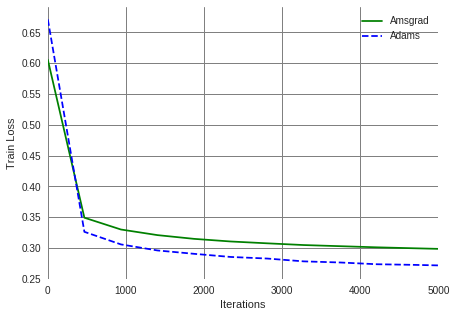

In [433]:
# Train loss
x = num_batches_train*np.arange(0,num_epochs)
plt.figure(figsize=(7,5))
actual, = plt.plot(x,train_loss_list_epoch, 'g', label="Amsgrad")
predicted, = plt.plot(x, train_loss_list_epoch_adam, 'b--', label ="Adams")
#t.title("Train loss with number of epochs")
plt.legend(handles=[actual,predicted])
plt.xlabel('Iterations')
plt.ylabel('Train Loss')
plt.grid(color='gray', linewidth=1)
plt.gca().set_facecolor('w')
plt.xlim(0,5000)
plt.show()

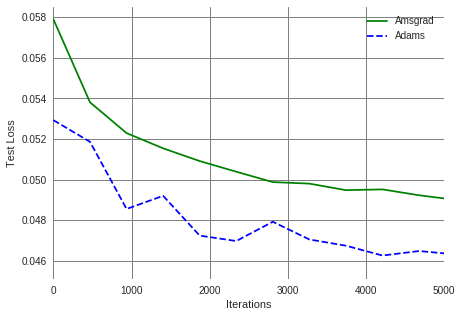

In [434]:

x = num_batches_train*np.arange(0,num_epochs)

plt.figure(figsize=(7,5))
actual, = plt.plot(x,test_loss_list_epoch, 'g', label="Amsgrad")
predicted, = plt.plot(x, test_loss_list_epoch_adam, 'b--', label ="Adams")
#plt.title("Validation loss with number of epochs")
plt.legend(handles=[actual,predicted])
plt.xlabel('Iterations')
plt.ylabel('Test Loss')
plt.grid(color='gray', linewidth=1)
plt.gca().set_facecolor('w')
plt.xlim(0,5000)
plt.show()